In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===========================
# Diffusion schedule
# ===========================
T = 1000
beta_start = 1e-4
beta_end   = 2e-2
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, dim=0)
sigmas = torch.sqrt(1.0 - alpha_bar)

# ===========================
# Data: mixture Gaussian -> point cloud
# ===========================
mu1 = torch.tensor([+2.0, 0.0, 0.0], device=device)
mu2 = torch.tensor([-2.0, 0.0, 0.0], device=device)

N_POINTS = 64

def sample_x0_cloud(batch_size: int, n_points: int = N_POINTS):
    B = batch_size
    mix = torch.bernoulli(0.5*torch.ones(B, n_points, device=device))  # (B,N)
    mu = torch.where(mix.unsqueeze(-1)==1, mu1, mu2)  # (B,N,3)
    eps = torch.randn(B, n_points, 3, device=device)
    return mu + eps


In [2]:
# ===========================
# Fourier time embedding
# ===========================
class FourierTimeEmbedding(nn.Module):
    def __init__(self, dim=64, max_freq=1000.0):
        super().__init__()
        self.freqs = torch.exp(
            torch.linspace(0, math.log(max_freq), dim//2)
        )

    def forward(self, t):
        t_norm = t.float() / float(T)
        args = t_norm.unsqueeze(-1) * self.freqs.to(t.device)
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

# ===========================
# EGNN Layer
# ===========================
class EGNNLayer(nn.Module):
    def __init__(self, time_dim=64, hidden_dim=64):
        super().__init__()
        
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_dim*2 + 1 + time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim, hidden_dim),
            nn.SiLU()
        )
        
        self.coord_mlp = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )
        
    def forward(self, x, h, t_emb):
        B, N, _ = x.shape
        
        diff = x.unsqueeze(2) - x.unsqueeze(1)  # (B, N, N, 3)
        r2 = (diff**2).sum(dim=-1, keepdim=True)
        
        # expand features
        h_i = h.unsqueeze(2).expand(-1, -1, N, -1)
        h_j = h.unsqueeze(1).expand(-1, N, -1, -1)
        
        t_in = t_emb.unsqueeze(1).unsqueeze(2).expand(B, N, N, -1)
        
        edge_in = torch.cat([h_i, h_j, r2, t_in], dim=-1)
        e_ij = self.edge_mlp(edge_in)
        
        # coordinate update
        w_ij = self.coord_mlp(e_ij)
        dx = (w_ij * diff).sum(dim=2)
        x = x + dx
        
        # feature update
        m_i = e_ij.sum(dim=2)
        h = self.node_mlp(torch.cat([h, m_i], dim=-1))
        
        return x, h


# ===========================
# EGNN model: predicts x0 (not score)
# ===========================
class EGNN_x0(nn.Module):
    def __init__(self, n_layers=3, time_dim=64, hidden_dim=64):
        super().__init__()
        
        self.t_emb = FourierTimeEmbedding(time_dim)
        
        # node feature MLP（你問的那段就在這裡）
        self.node_mlp = nn.Sequential(
            nn.Linear(3 + time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.layers = nn.ModuleList([
            EGNNLayer(time_dim=time_dim, hidden_dim=hidden_dim)
            for _ in range(n_layers)
        ])

        self.out_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 3, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, x_t, t):
        B, N, _ = x_t.shape
        t_emb = self.t_emb(t)  # (B, time_dim)

        # ⭐⭐ 你問的這行就在這裡 ⭐⭐
        h = self.node_mlp(torch.cat([
            x_t,
            t_emb.unsqueeze(1).expand(B, N, -1)
        ], dim=-1))   # → (B, N, hidden_dim)

        x = x_t

        for layer in self.layers:
            x, h = layer(x, h, t_emb)   # 需要 EGNNLayer 支援 feature

        # x + h 一起進 out MLP
        out = self.out_mlp(torch.cat([x, h], dim=-1))
        return out

model = EGNN_x0().to(device)


In [5]:
# ===========================
# Loss: predict x0
# ===========================
def loss_x0(model, batch_size):
    x0 = sample_x0_cloud(batch_size)

    t = torch.randint(int(0.2 * T), T, (batch_size,), device=device)
    alpha_bar_t = alpha_bar[t].view(-1,1,1)
    sigma_t     = sigmas[t].view(-1,1,1)

    eps = torch.randn_like(x0)
    x_t = torch.sqrt(alpha_bar_t)*x0 + sigma_t*eps

    x0_hat = model(x_t, t)

    return ((x0_hat - x0)**2).mean()

# ===========================
# Training loop
# ===========================
batch_size = 8
lr = 2e-4
num_steps = 5000

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=200,
    cooldown=100,
    min_lr=1e-8
)
loss_history = []

model.train()
for step in range(1, num_steps+1):
    loss = loss_x0(model, batch_size)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:5d} | loss={loss.item():.4f} | Lr={lr:.6f}")


step   200 | loss=2.3189 | Lr=0.000200
step   400 | loss=1.9119 | Lr=0.000200
step   600 | loss=1.4949 | Lr=0.000200
step   800 | loss=2.0884 | Lr=0.000200
step  1000 | loss=1.9000 | Lr=0.000200
step  1200 | loss=1.7665 | Lr=0.000200
step  1400 | loss=1.5820 | Lr=0.000200
step  1600 | loss=2.0650 | Lr=0.000200
step  1800 | loss=1.7211 | Lr=0.000200
step  2000 | loss=1.7610 | Lr=0.000200
step  2200 | loss=1.9719 | Lr=0.000200
step  2400 | loss=1.6600 | Lr=0.000200
step  2600 | loss=2.1633 | Lr=0.000200
step  2800 | loss=1.8541 | Lr=0.000200
step  3000 | loss=1.9127 | Lr=0.000200
step  3200 | loss=1.5964 | Lr=0.000200
step  3400 | loss=1.1556 | Lr=0.000200
step  3600 | loss=1.3789 | Lr=0.000200
step  3800 | loss=1.5277 | Lr=0.000200
step  4000 | loss=1.8666 | Lr=0.000200
step  4200 | loss=1.6447 | Lr=0.000200
step  4400 | loss=1.8678 | Lr=0.000200
step  4600 | loss=1.5685 | Lr=0.000200
step  4800 | loss=1.7065 | Lr=0.000200
step  5000 | loss=1.6948 | Lr=0.000200


In [7]:
@torch.no_grad()
def debug_x0_prediction():
    t = torch.randint(int(0.1*T), T, (1,), device=device)
    x0 = sample_x0_cloud(1)
    alpha_bar_t = alpha_bar[t].view(-1,1,1)
    sigma_t = sigmas[t].view(-1,1,1)
    eps = torch.randn_like(x0)
    x_t = torch.sqrt(alpha_bar_t)*x0 + sigma_t*eps
    x0_hat = model(x_t, t)
    print("t =", t.item())
    print("x0_hat mean:", x0_hat.mean().item())
    print("x0_hat std :", x0_hat.std().item())
    print("x0_hat min :", x0_hat.min().item())
    print("x0_hat max :", x0_hat.max().item())
    return x_t.cpu(), x0.cpu(), x0_hat.cpu()


x_t, x0, x0_hat = debug_x0_prediction()
print(x0_hat.mean(), x0_hat.std())


t = 860
x0_hat mean: -0.0012034112587571144
x0_hat std : 0.08432726562023163
x0_hat min : -0.2945207357406616
x0_hat max : 0.2531454265117645
tensor(-0.0012) tensor(0.0843)


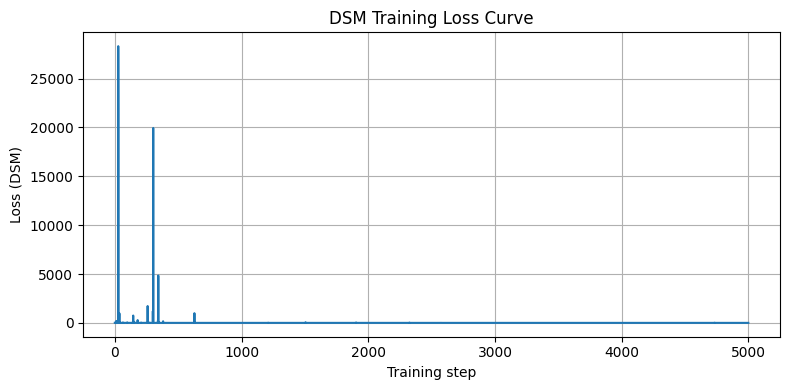

In [8]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

## 試著做做看 validation loss

In [9]:
@torch.no_grad()
def val_loss_x0(model, batch_size):
    x0 = sample_x0_cloud(batch_size)
    t = torch.randint(int(0.1*T), T, (batch_size,), device=device)

    alpha_bar_t = alpha_bar[t].view(-1,1,1)
    sigma_t     = sigmas[t].view(-1,1,1)

    eps = torch.randn_like(x0)
    x_t = torch.sqrt(alpha_bar_t)*x0 + sigma_t*eps

    x0_hat = model(x_t, t)

    return ((x0_hat - x0)**2).mean().item()

if step % 500 == 0:
    vloss = val_loss_x0(model, batch_size)
    print(f"[VAL] step {step} | val_loss={vloss:.4f}")


[VAL] step 5000 | val_loss=2.2240


## Reverse Diffusion

In [ ]:
@torch.no_grad()
def reverse_sample_score(model, num_samples=200, n_points=N_POINTS):
    model.eval()

    x = torch.randn(num_samples, n_points, 3, device=device)

    for t_idx in reversed(range(T)):
        t = torch.full((num_samples,), t_idx, device=device, dtype=torch.long)

        # score model output
        score = model(x, t)  # shape (B,N,3)

        beta = betas[t_idx]
        alpha = alphas[t_idx]

        # reverse ODE (deterministic)
        drift = -0.5 * beta * (x + score)
        x = x + drift  # dt=1 scaled into beta

    return x.cpu()


In [11]:
# Step A: inspect model's x0 prediction
@torch.no_grad()
def debug_x0_prediction():
    # choose some random t
    t = torch.randint(int(0.1*T), T, (1,), device=device)

    # generate random x_t (same way training produces it)
    x0 = sample_x0_cloud(batch_size=1)        # (1, N, 3)

    alpha_bar_t = alpha_bar[t].view(-1,1,1)
    sigma_t     = sigmas[t].view(-1,1,1)

    eps = torch.randn_like(x0)
    x_t = torch.sqrt(alpha_bar_t) * x0 + sigma_t * eps

    # feed into model
    x0_hat = model(x_t, t)

    # print statistics
    print("t =", t.item())
    print("x0_hat mean:", x0_hat.mean().item())
    print("x0_hat std :", x0_hat.std().item())
    print("x0_hat min :", x0_hat.min().item())
    print("x0_hat max :", x0_hat.max().item())

    return x_t.cpu(), x0.cpu(), x0_hat.cpu()

# run it
x_t_debug, x0_debug, x0hat_debug = debug_x0_prediction()



t = 525
x0_hat mean: -0.06219947710633278
x0_hat std : 0.6486223340034485
x0_hat min : -2.3020997047424316
x0_hat max : 1.95256769657135


## Visualization

In [12]:
import matplotlib.pyplot as plt

def plot_scatter_2d(samples):
    # samples shape = (B, N, 3)
    pts = samples.reshape(-1, 3)
    x = pts[:,0]
    y = pts[:,1]

    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=5, alpha=0.5)
    plt.title("Reverse Diffusion: 2D Scatter (x-y plane)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()


In [13]:
def plot_histogram_x(samples):
    pts = samples.reshape(-1, 3)
    x = pts[:,0]

    plt.figure(figsize=(6,4))
    plt.hist(x, bins=50, density=True, alpha=0.7)
    plt.title("1D Histogram of x (should show bimodal mixture)")
    plt.xlabel("x")
    plt.ylabel("density")
    plt.grid(True)
    plt.show()


In [14]:
import seaborn as sns
import numpy as np

def plot_kde_heatmap(samples):
    pts = samples.reshape(-1, 3)
    x = pts[:,0]
    y = pts[:,1]

    plt.figure(figsize=(6,5))
    sns.kdeplot(x=x, y=y, fill=True, cmap="viridis", thresh=0.05, levels=30)
    plt.title("2D KDE Heatmap (Density of Generated Samples)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


In [15]:
from mpl_toolkits.mplot3d import Axes3D

def plot_scatter_3d(samples):
    pts = samples.reshape(-1, 3)
    x = pts[:,0]
    y = pts[:,1]
    z = pts[:,2]

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, s=5, alpha=0.4)

    ax.set_title("3D Scatter of Generated Samples")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    plt.show()


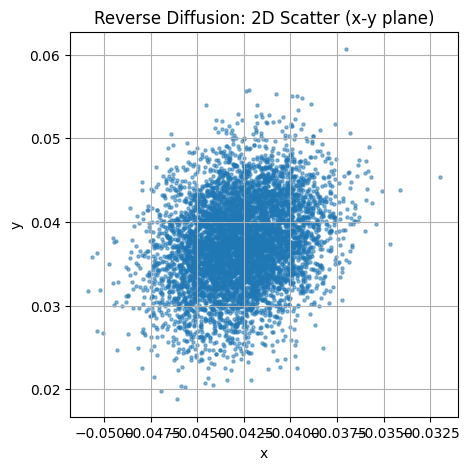

In [16]:
samples = reverse_sample(model, num_samples=200, n_points=32)

plot_scatter_2d(samples)


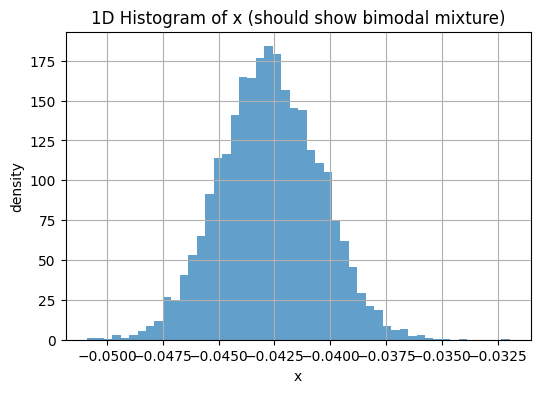

In [17]:
plot_histogram_x(samples)


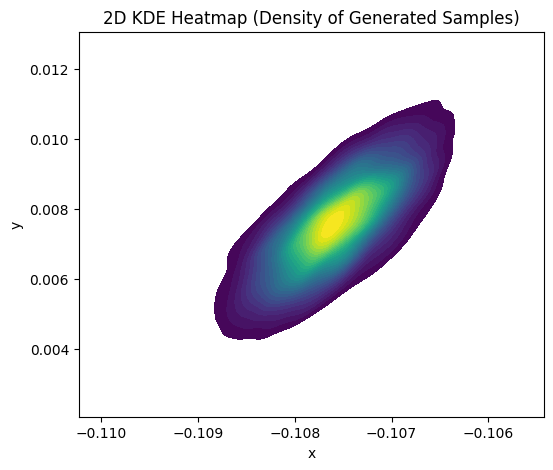

In [23]:
plot_kde_heatmap(samples)


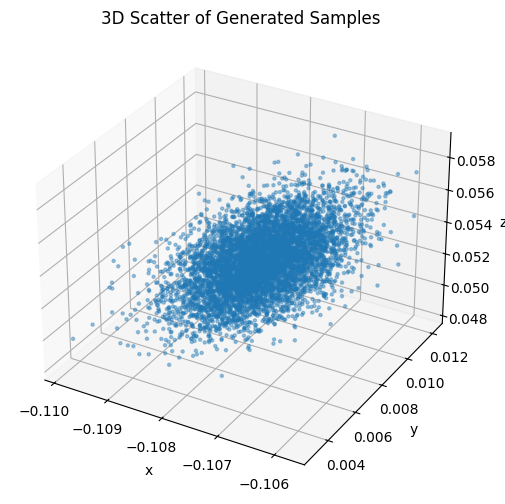

In [24]:
plot_scatter_3d(samples)
